# Myeloid cell-cell interactions

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata
import joblib
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
from plotnine import *
import scvelo as scv
import scipy as sp

In [2]:
sc.set_figure_params()
scv.set_figure_params(vector_friendly=False)

In [3]:
sc.settings.figdir = 'figure'
scv.settings.figdir = 'figure'

In [4]:
import sys
from pathlib import Path

sys.path.append(str(Path.home() / 'Code/sctoolkit'))

In [5]:
from sctoolkit.specificity import get_gene_specificity_metricsv2
from sctoolkit.sctransform import sctransform
from sctoolkit.utils import run_spring, dotplot_spring, sort_by_correlation, plot_significance_dotplot
from sctoolkit.revigo import revigo
from sctoolkit.proportions import plot_proportion_barplot, dirichletreg, plot_proportion_barplot_with_ncells, get_proportions_per_channel

In [6]:
full = sc.read('adata.h5ad')

In [7]:
ad = sc.read('myeloids.h5ad')
ad.shape

(14156, 16150)

In [8]:
full = full[~full.obs_names.isin(ad.obs_names)].copy()
full.obs['myeloid'] = False
ad.obs['myeloid'] = True
ad.obs['Broad cell type'] = ad.obs.annotation

In [9]:
full._sanitize()

In [10]:
full = sc.concat([full, ad])

In [13]:
cpdb = pd.read_pickle('cpdb.pkl')

In [15]:
cpdb

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin
0,CPI-SS044DF8749,KLRG2_WNT5B,simple:A4D1S0,simple:Q9H1J7,KLRG2,WNT5B,True,True,False,InnateDB-All,False
1,CPI-SS0B84DAE3D,PVR_CD96,simple:P15151,simple:P40200,PVR,CD96,True,True,True,curated,False
2,CPI-SS0A8627ED6,PVR_CD226,simple:P15151,simple:Q15762,PVR,CD226,True,True,True,curated,False
3,CPI-SS00561BBD7,PVR_TIGIT,simple:P15151,simple:Q495A1,PVR,TIGIT,True,True,False,curated,False
4,CPI-SS0889E281D,CADM1_CADM1,simple:Q9BY67,simple:Q9BY67,CADM1,CADM1,False,False,False,curated,False
...,...,...,...,...,...,...,...,...,...,...,...
1741,CPI-SC0BAB29E69,F2_a2Bb3 complex,simple:P00734,complex:a2Bb3 complex,F2,ITGB3,True,False,False,curated,True
1742,CPI-SC0E16B866E,IFNW1_Type I IFNR,simple:P05000,complex:Type I IFNR,IFNW1,IFNAR1,True,False,True,curated,False
1743,CPI-SC0E16B866E,IFNW1_Type I IFNR,simple:P05000,complex:Type I IFNR,IFNW1,IFNAR2,True,False,True,curated,False
1744,CPI-SS06CF55F94,INSL3_RXFP2,simple:P51460,simple:Q8WXD0,INSL3,RXFP2,True,False,True,guidetopharmacology.org,False


## Tissues

In [16]:
all_cpdb = []
immunes = {}
nonimmunes = {}

t =  'all'

sub = full.copy() #[full.obs.tissue == t].copy()

immune = sub[sub.obs.myeloid].copy()
ct = immune.obs['Broad cell type'].value_counts()>=10
ct = ct[ct].index
immune = immune[immune.obs['Broad cell type'].isin(ct)].copy()
immune._sanitize()

immune.layers['scaled'] = immune.X.copy()
sc.pp.scale(immune, max_value=3, layer='scaled')
immunes[t] = immune

immune_zscore = pd.DataFrame(immune.layers['scaled'], index=immune.obs_names, columns=immune.var_names).groupby(immune.obs['Broad cell type']).mean().reset_index().melt('Broad cell type', var_name='gene', value_name='zscore')
immune_zscore = immune_zscore[immune_zscore.zscore>0.1].reset_index(drop=True)
#immune_zscore = immune_zscore.T.reset_index().rename(columns={'index': 'gene'})

nonimmune = sub[~sub.obs.myeloid].copy()
ct = nonimmune.obs['Broad cell type'].value_counts()>=5
ct = ct[ct].index
nonimmune = nonimmune[nonimmune.obs['Broad cell type'].isin(ct)].copy()
nonimmune._sanitize()

nonimmune.layers['scaled'] = nonimmune.X.copy()
sc.pp.scale(nonimmune, max_value=3, layer='scaled')
nonimmunes[t] = nonimmune

nonimmune_zscore = pd.DataFrame(nonimmune.layers['scaled'], index=nonimmune.obs_names, columns=nonimmune.var_names).groupby(nonimmune.obs['Broad cell type']).mean().reset_index().melt('Broad cell type', var_name='gene', value_name='zscore')
nonimmune_zscore = nonimmune_zscore[nonimmune_zscore.zscore>0.1].reset_index(drop=True)
#nonimmune_zscore = nonimmune_zscore.T.reset_index().rename(columns={'index': 'gene'})

cpdb_ab = cpdb.merge(immune_zscore, left_on='gene_a', right_on='gene', how='left').drop('gene', axis=1).rename(columns={'zscore': 'zscore_immune', 'Broad cell type': 'celltype_immune'})
cpdb_ab = cpdb_ab.merge(nonimmune_zscore, left_on='gene_b', right_on='gene', how='left').drop('gene', axis=1).rename(columns={'zscore': 'zscore_nonimmune', 'Broad cell type': 'celltype_nonimmune'})

cpdb_ba = cpdb.merge(immune_zscore, left_on='gene_b', right_on='gene', how='left').drop('gene', axis=1).rename(columns={'zscore': 'zscore_immune', 'Broad cell type': 'celltype_immune'})
cpdb_ba = cpdb_ba.merge(nonimmune_zscore, left_on='gene_a', right_on='gene', how='left').drop('gene', axis=1).rename(columns={'zscore': 'zscore_nonimmune', 'Broad cell type': 'celltype_nonimmune'})

cpdb_ab['mean_zscore'] = (cpdb_ab.zscore_immune + cpdb_ab.zscore_nonimmune) / 2
cpdb_ba['mean_zscore'] = (cpdb_ba.zscore_immune + cpdb_ba.zscore_nonimmune) / 2

cpdb_ab = cpdb_ab[cpdb_ab.celltype_immune.isin(['LAM-like', 'MΦ HLAII hi', 'MΦ LYVE1 hi'])]
cpdb_ba = cpdb_ba[cpdb_ba.celltype_immune.isin(['LAM-like', 'MΦ HLAII hi', 'MΦ LYVE1 hi'])]

pa = cpdb_ba.partner_a.copy()
ga = cpdb_ba.gene_a.copy()
ra = cpdb_ba.receptor_a.copy()

cpdb_ba['partner_a'] = cpdb_ba['partner_b']
cpdb_ba['gene_a'] = cpdb_ba['gene_b']
cpdb_ba['receptor_a'] = cpdb_ba['receptor_b']

cpdb_ba['partner_b'] = pa
cpdb_ba['gene_b'] = ga
cpdb_ba['receptor_b'] = ra

cpdb_ba['ab_order'] = 'ba'
cpdb_ab['ab_order'] = 'ab'

cpdb_final = pd.concat([cpdb_ab, cpdb_ba]).reset_index(drop=True).rename(columns={'celltype_immune': 'celltype_a', 'celltype_nonimmune': 'celltype_b'})
all_cpdb.append(cpdb_final.assign(tissue=t))

all_cpdb = pd.concat(all_cpdb, axis=0).reset_index(drop=True)

... storing 'Sample ID' as categorical
... storing 'Sample ID short' as categorical
... storing 'barcode' as categorical
... storing 'batch' as categorical
... storing 'Broad cell type' as categorical
... storing 'leiden' as categorical
... storing 'Tissue' as categorical
... storing 'Sample ID' as categorical
... storing 'Sample ID short' as categorical
... storing 'barcode' as categorical
... storing 'batch' as categorical
... storing 'Broad cell type' as categorical
... storing 'leiden' as categorical
... storing 'Tissue' as categorical


In [17]:
pd.options.display.max_rows = 100

In [18]:
all_cpdb_strict = all_cpdb[(all_cpdb.zscore_immune>.5) & (all_cpdb.zscore_nonimmune>.5) & (~all_cpdb.gene_a.str.startswith('COL')) & (~all_cpdb.gene_b.str.startswith('COL'))].sort_values('mean_zscore', ascending=False).drop_duplicates(['gene_a', 'gene_b', 'celltype_a', 'celltype_b', 'tissue'])

In [19]:
all_cpdb_strict

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,celltype_a,zscore_immune,celltype_b,zscore_nonimmune,mean_zscore,ab_order,tissue
217,CPI-SS076BC3BA6,HLA-DPB1_NRG1,simple:HLADPB1,simple:Q02297,HLA-DPB1,NRG1,True,True,True,InnateDB-All,False,MΦ HLAII hi,1.038149,Neuroendocrine,2.782511,1.910330,ab,all
1976,CPI-SS080611C5B,ALOX5_ALOX5AP,simple:P20292,simple:P09917,ALOX5AP,ALOX5,False,False,False,guidetopharmacology.org,False,MΦ HLAII hi,0.956118,Immune (Langerhans),2.648208,1.802163,ba,all
218,CPI-SS076BC3BA6,HLA-DPB1_NRG1,simple:HLADPB1,simple:Q02297,HLA-DPB1,NRG1,True,True,True,InnateDB-All,False,MΦ HLAII hi,1.038149,Neuronal,1.983505,1.510827,ab,all
1332,CPI-SS072B19293,HLA-DPA1_GAL,simple:HLADPA1,simple:P22466,HLA-DPA1,GAL,True,True,False,InnateDB-All,False,MΦ HLAII hi,1.037275,Neuronal,1.895490,1.466383,ab,all
1404,CPI-SC0988E0218,SPP1_aVb3 complex,simple:P10451,complex:aVb3 complex,SPP1,ITGAV,True,False,False,curated,True,LAM-like,1.444613,Immune (Langerhans),1.180663,1.312638,ab,all
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128,CPI-SS03EF699C7,HLA-E_KLRC1,simple:P13747,simple:P26715,HLA-E,KLRC1,False,False,True,curated,False,MΦ HLAII hi,0.564591,Immune (NK cell),0.554700,0.559646,ab,all
1863,CPI-SS00D9A0644,FGFR2_CD83,simple:Q01151,simple:P21802,CD83,FGFR2,True,True,True,InnateDB-All,False,LAM-like,0.536477,Myofibroblast,0.578190,0.557334,ba,all
1862,CPI-SS00D9A0644,FGFR2_CD83,simple:Q01151,simple:P21802,CD83,FGFR2,True,True,True,InnateDB-All,False,LAM-like,0.536477,Myoepithelial (basal),0.535823,0.536150,ba,all
3420,CPI-SC0D9B795CC,CDH1_a2b1 complex,complex:a2b1 complex,simple:P12830,ITGB1,CDH1,False,False,False,curated,True,MΦ HLAII hi,0.521464,Epithelial cell (Hillock),0.511480,0.516472,ba,all


In [20]:
all_cpdb_strict[all_cpdb_strict.celltype_a == 'LAM-like']

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,celltype_a,zscore_immune,celltype_b,zscore_nonimmune,mean_zscore,ab_order,tissue
1404,CPI-SC0988E0218,SPP1_aVb3 complex,simple:P10451,complex:aVb3 complex,SPP1,ITGAV,True,False,False,curated,True,LAM-like,1.444613,Immune (Langerhans),1.180663,1.312638,ab,all
842,CPI-SC01AB9BED7,SPP1_a9b1 complex,simple:P10451,complex:a9b1 complex,SPP1,ITGA9,True,False,False,curated,True,LAM-like,1.444613,Endothelial cell (lymphatic),1.047738,1.246176,ab,all
863,CPI-SC01AB9BED7,SPP1_a9b1 complex,simple:P10451,complex:a9b1 complex,SPP1,ITGB1,True,False,False,curated,True,LAM-like,1.444613,"Myocyte (cardiac, cytoplasmic)",1.030792,1.237703,ab,all
9,CPI-SS02AB0C3E0,SPP1_CD44,simple:P10451,simple:P16070,SPP1,CD44,True,False,True,"I2D,IMEx,InnateDB-All,IntAct",False,LAM-like,1.444613,Epithelial cell (Hillock),0.988981,1.216797,ab,all
0,CPI-SS0889E281D,CADM1_CADM1,simple:Q9BY67,simple:Q9BY67,CADM1,CADM1,False,False,False,curated,False,LAM-like,0.575513,Epithelial cell (alveolar type I),1.824584,1.200048,ab,all
12,CPI-SS02AB0C3E0,SPP1_CD44,simple:P10451,simple:P16070,SPP1,CD44,True,False,True,"I2D,IMEx,InnateDB-All,IntAct",False,LAM-like,1.444613,Epithelial cell (basal),0.911313,1.177963,ab,all
3693,CPI-SC0A9458008,ICAM1_aXb2 complex,complex:aXb2 complex,simple:P05362,ITGAX,ICAM1,False,False,True,curated,True,LAM-like,1.464726,Epithelial cell (alveolar type I),0.884662,1.174694,ba,all
24,CPI-SS02AB0C3E0,SPP1_CD44,simple:P10451,simple:P16070,SPP1,CD44,True,False,True,"I2D,IMEx,InnateDB-All,IntAct",False,LAM-like,1.444613,Melanocyte,0.846313,1.145463,ab,all
16,CPI-SS02AB0C3E0,SPP1_CD44,simple:P10451,simple:P16070,SPP1,CD44,True,False,True,"I2D,IMEx,InnateDB-All,IntAct",False,LAM-like,1.444613,Epithelial cell (suprabasal),0.843059,1.143836,ab,all
864,CPI-SC01AB9BED7,SPP1_a9b1 complex,simple:P10451,complex:a9b1 complex,SPP1,ITGB1,True,False,False,curated,True,LAM-like,1.444613,Myocyte (smooth muscle),0.838071,1.141342,ab,all


In [21]:
all_cpdb_strict[all_cpdb_strict.celltype_a == 'MΦ LYVE1 hi']

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,celltype_a,zscore_immune,celltype_b,zscore_nonimmune,mean_zscore,ab_order,tissue


In [22]:
all_cpdb_strict[all_cpdb_strict.celltype_a == 'MΦ HLAII hi']

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,celltype_a,zscore_immune,celltype_b,zscore_nonimmune,mean_zscore,ab_order,tissue
217,CPI-SS076BC3BA6,HLA-DPB1_NRG1,simple:HLADPB1,simple:Q02297,HLA-DPB1,NRG1,True,True,True,InnateDB-All,False,MΦ HLAII hi,1.038149,Neuroendocrine,2.782511,1.910330,ab,all
1976,CPI-SS080611C5B,ALOX5_ALOX5AP,simple:P20292,simple:P09917,ALOX5AP,ALOX5,False,False,False,guidetopharmacology.org,False,MΦ HLAII hi,0.956118,Immune (Langerhans),2.648208,1.802163,ba,all
218,CPI-SS076BC3BA6,HLA-DPB1_NRG1,simple:HLADPB1,simple:Q02297,HLA-DPB1,NRG1,True,True,True,InnateDB-All,False,MΦ HLAII hi,1.038149,Neuronal,1.983505,1.510827,ab,all
1332,CPI-SS072B19293,HLA-DPA1_GAL,simple:HLADPA1,simple:P22466,HLA-DPA1,GAL,True,True,False,InnateDB-All,False,MΦ HLAII hi,1.037275,Neuronal,1.895490,1.466383,ab,all
3468,CPI-SC0ED0520DD,LAMA3_a3b1 complex,complex:a3b1 complex,simple:Q16787,ITGB1,LAMA3,True,False,False,curated,True,MΦ HLAII hi,0.521464,Epithelial cell (basal keratinocyte),2.072843,1.297153,ba,all
3467,CPI-SC0ED0520DD,LAMA3_a3b1 complex,complex:a3b1 complex,simple:Q16787,ITGB1,LAMA3,True,False,False,curated,True,MΦ HLAII hi,0.521464,Epithelial cell (alveolar type I),1.956559,1.239011,ba,all
1977,CPI-SS080611C5B,ALOX5_ALOX5AP,simple:P20292,simple:P09917,ALOX5AP,ALOX5,False,False,False,guidetopharmacology.org,False,MΦ HLAII hi,0.956118,Immune (alveolar macrophage),1.518928,1.237523,ba,all
707,CPI-SC0D19BAF15,FN1_a10b1 complex,simple:P02751,complex:a10b1 complex,FN1,ITGA10,True,False,False,curated,True,MΦ HLAII hi,0.829387,Myocyte (NMJ-rich),1.613515,1.221451,ab,all
784,CPI-SC08B2AD7C6,FN1_a5b1 complex,simple:P02751,complex:a5b1 complex,FN1,ITGA5,True,False,False,curated,True,MΦ HLAII hi,0.829387,Myofibroblast,1.546571,1.187979,ab,all
1321,CPI-CS0123BC66C,PlexinA1_complex2_SEMA6D,complex:PlexinA1_complex2,simple:Q8NFY4,TYROBP,SEMA6D,False,True,False,curated,False,MΦ HLAII hi,1.007722,Neuronal,1.323740,1.165731,ab,all


In [23]:
all_cpdb_strict[all_cpdb_strict.celltype_b.str.startswith('Endothelial')]

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,celltype_a,zscore_immune,celltype_b,zscore_nonimmune,mean_zscore,ab_order,tissue
842,CPI-SC01AB9BED7,SPP1_a9b1 complex,simple:P10451,complex:a9b1 complex,SPP1,ITGA9,True,False,False,curated,True,LAM-like,1.444613,Endothelial cell (lymphatic),1.047738,1.246176,ab,all
273,CPI-SS09808DEAE,CD74_APP,simple:P04233,simple:P05067,CD74,APP,False,True,False,curated,False,MΦ HLAII hi,0.975194,Endothelial cell (lymphatic),1.105971,1.040583,ab,all
274,CPI-SS09808DEAE,CD74_APP,simple:P04233,simple:P05067,CD74,APP,False,True,False,curated,False,MΦ HLAII hi,0.975194,Endothelial cell (vascular),0.676920,0.826057,ab,all
1748,CPI-SS0241A1F57,NRP2_SEMA3C,simple:Q99985,simple:O60462,SEMA3C,NRP2,True,False,True,curated,False,LAM-like,0.760765,Endothelial cell (lymphatic),0.660238,0.710502,ba,all
4140,CPI-SC070D5A96F,JAM2_a4b1 complex,complex:a4b1 complex,simple:P57087,ITGB1,JAM2,False,False,False,curated,True,MΦ HLAII hi,0.521464,Endothelial cell (vascular),0.511418,0.516441,ba,all


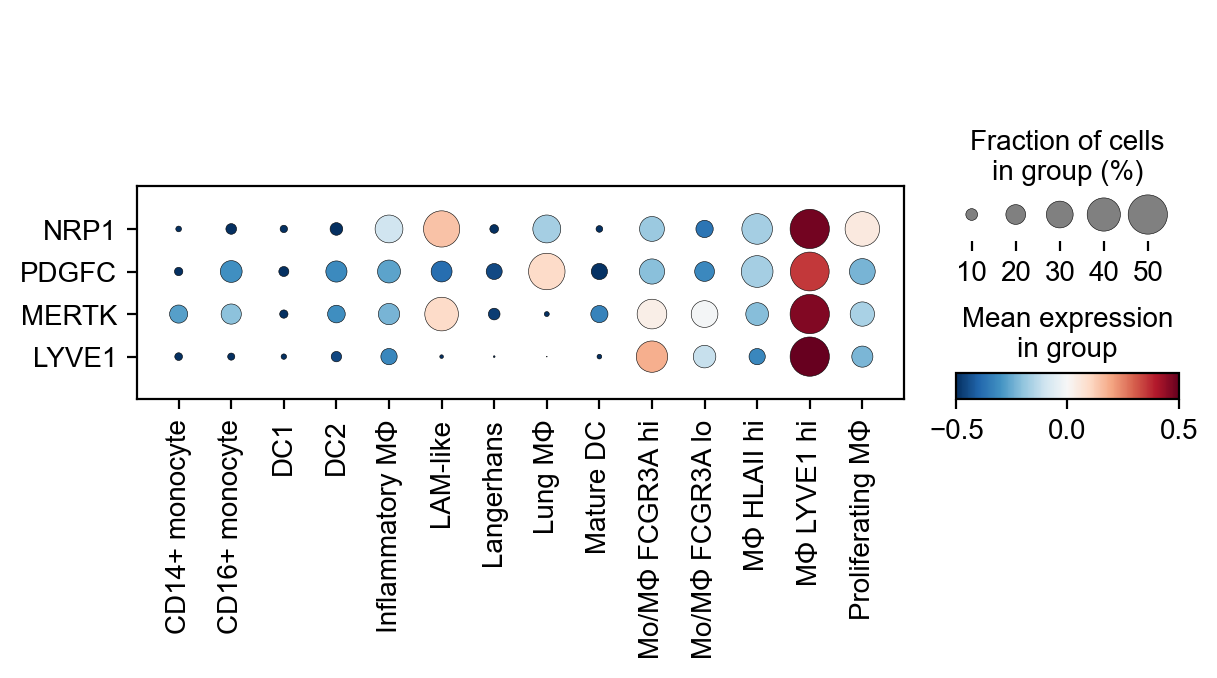

In [24]:
sc.pl.dotplot(immunes['all'], ['NRP1', 'PDGFC', 'MERTK', 'LYVE1'], 'Broad cell type', layer='scaled', vmin=-.5, vmax=.5, dot_max=.5, cmap='RdBu_r', swap_axes=True, save='lyve1-RL-immune.pdf')

In [25]:
nonimmune_ad = nonimmunes['all'][nonimmunes['all'].obs['Broad cell type'].str.startswith('Adipocyte') | nonimmunes['all'].obs['Broad cell type'].str.startswith('Endothelial cell (lym')|nonimmunes['all'].obs['Broad cell type'].str.startswith('Myocyte')|nonimmunes['all'].obs['Broad cell type'].str.startswith('Fibroblast')]

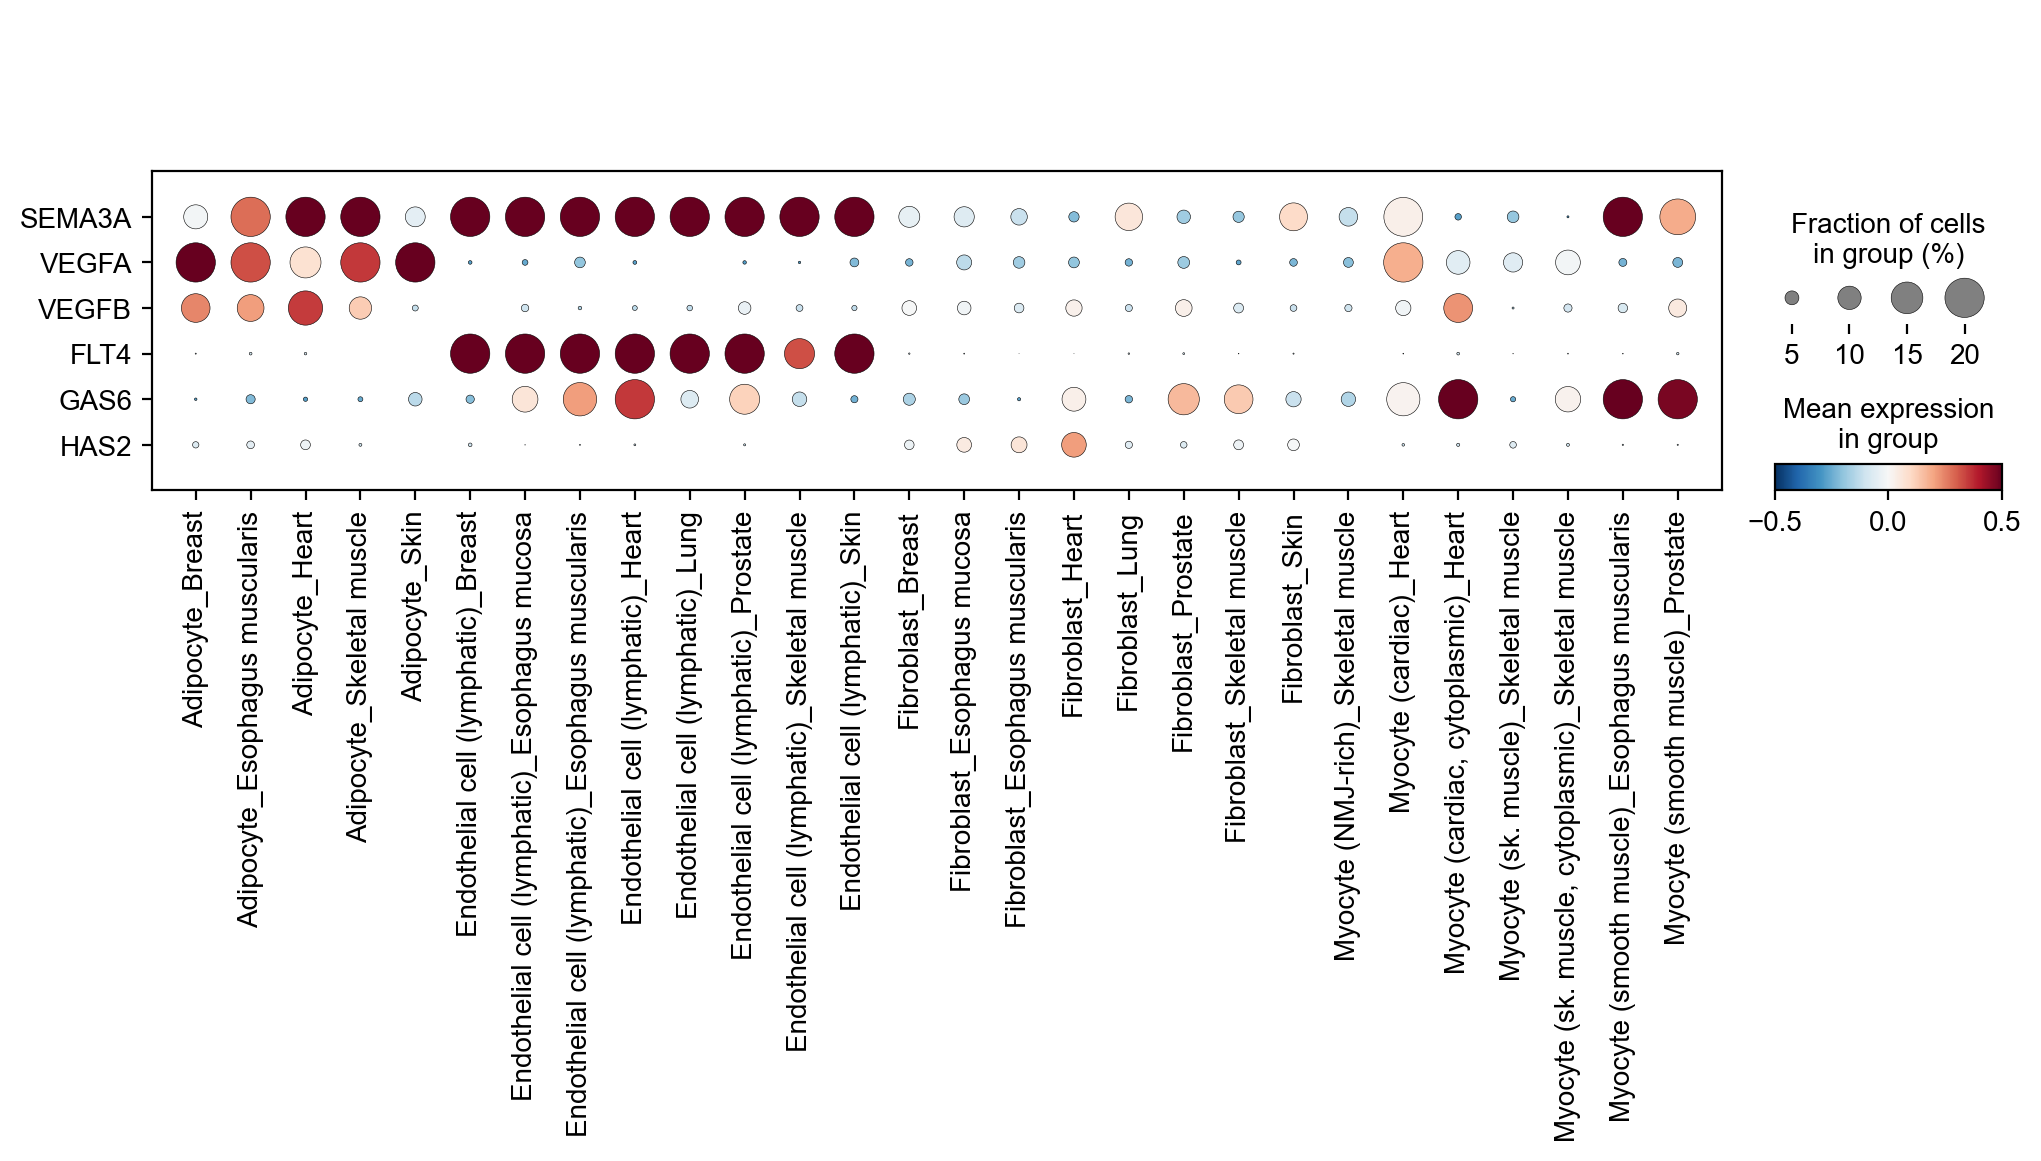

In [26]:
sc.pl.dotplot(nonimmune_ad, ['SEMA3A', 'VEGFA', 'VEGFB', 'FLT4', 'GAS6', 'HAS2'], ['Broad cell type', 'Tissue'], layer='scaled', vmin=-.5, vmax=.5, dot_max=.2, cmap='RdBu_r', swap_axes=True, save='lyve1-RL-nonimmune.pdf')

In [28]:
#HLA-E-KLRD1, ALOX5AP-ALOX5, CCR1-CCL5, ACKR4-CCL21, IL15-IL2RB, CCR1-CCL3, LTBR-LTB

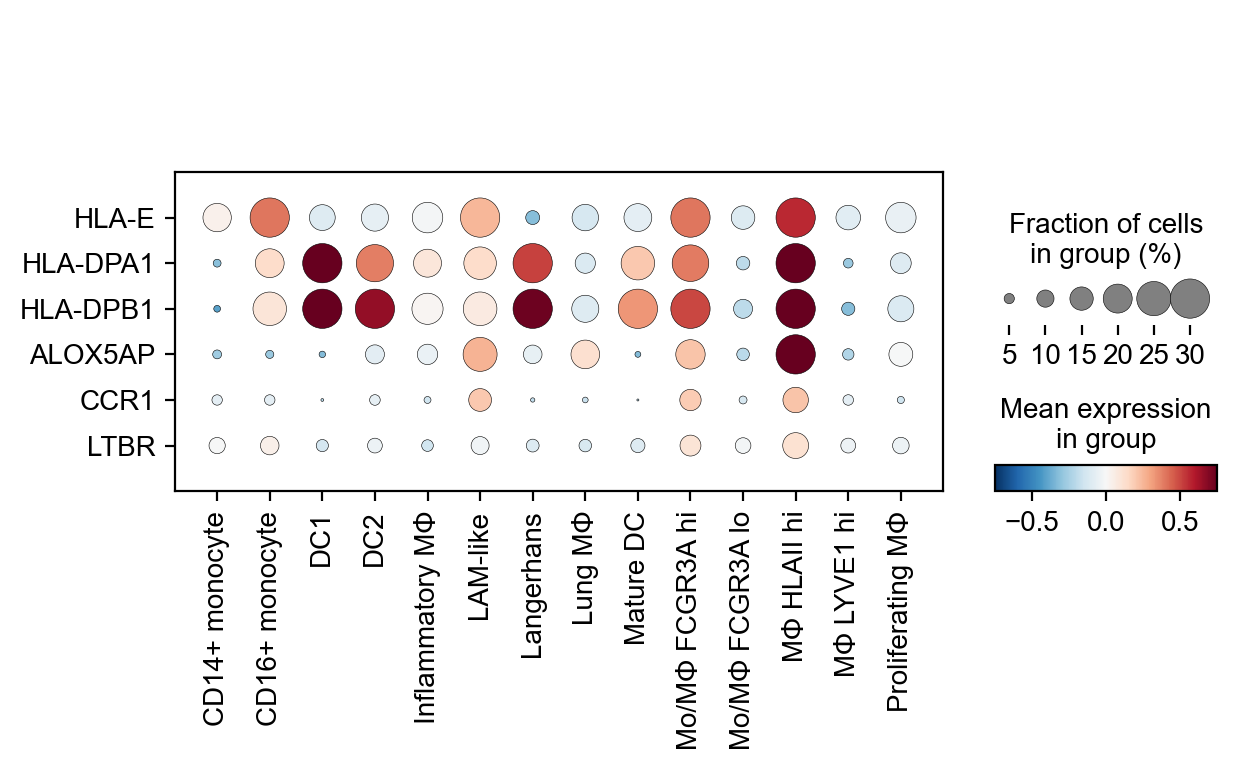

In [46]:
sc.pl.dotplot(immunes['all'], ['HLA-E', 'HLA-DPA1', 'HLA-DPB1', 'ALOX5AP', 'CCR1', 'LTBR'], ['Broad cell type'], layer='scaled', vmin=-.75, vmax=.75, dot_max=.3, cmap='RdBu_r', swap_axes=True, save='hlaII-RL-immune.pdf')

In [30]:
tmp = nonimmunes['all'][~(nonimmunes['all'].obs['Broad cell type'].str.startswith('Epithelial')|nonimmunes['all'].obs['Broad cell type'].str.startswith('Adipocyte'))]

In [31]:
tmp.obs['Broad cell type'].cat.categories

Index(['Endothelial cell (lymphatic)', 'Endothelial cell (vascular)',
       'Fibroblast', 'ICCs', 'Immune (B cell)', 'Immune (DC)',
       'Immune (DC/macrophage)', 'Immune (Langerhans)', 'Immune (NK cell)',
       'Immune (T cell)', 'Immune (alveolar macrophage)', 'Immune (mast cell)',
       'Melanocyte', 'Mucous cell', 'Myocyte (NMJ-rich)', 'Myocyte (cardiac)',
       'Myocyte (cardiac, cytoplasmic)', 'Myocyte (sk. muscle)',
       'Myocyte (sk. muscle, cytoplasmic)', 'Myocyte (smooth muscle)',
       'Myoepithelial (basal)', 'Myofibroblast', 'Neuroendocrine', 'Neuronal',
       'Pericyte/SMC', 'Satellite cell', 'Schwann cell',
       'Sebaceous gland cell', 'Sweat gland cell', 'Unknown'],
      dtype='object')

In [44]:
types = ['Immune (B cell)', 'Immune (DC)', 'Immune (DC/macrophage)', 'Immune (Langerhans)', 'Immune (NK cell)', 'Immune (T cell)', 'Immune (alveolar macrophage)', 'Immune (mast cell)', 'Myocyte (NMJ-rich)', 'Myocyte (cardiac)',
       'Myocyte (cardiac, cytoplasmic)', 'Myocyte (sk. muscle)', 'Myocyte (sk. muscle, cytoplasmic)', 'Myocyte (smooth muscle)', 'Neuronal', 'Neuroendocrine']

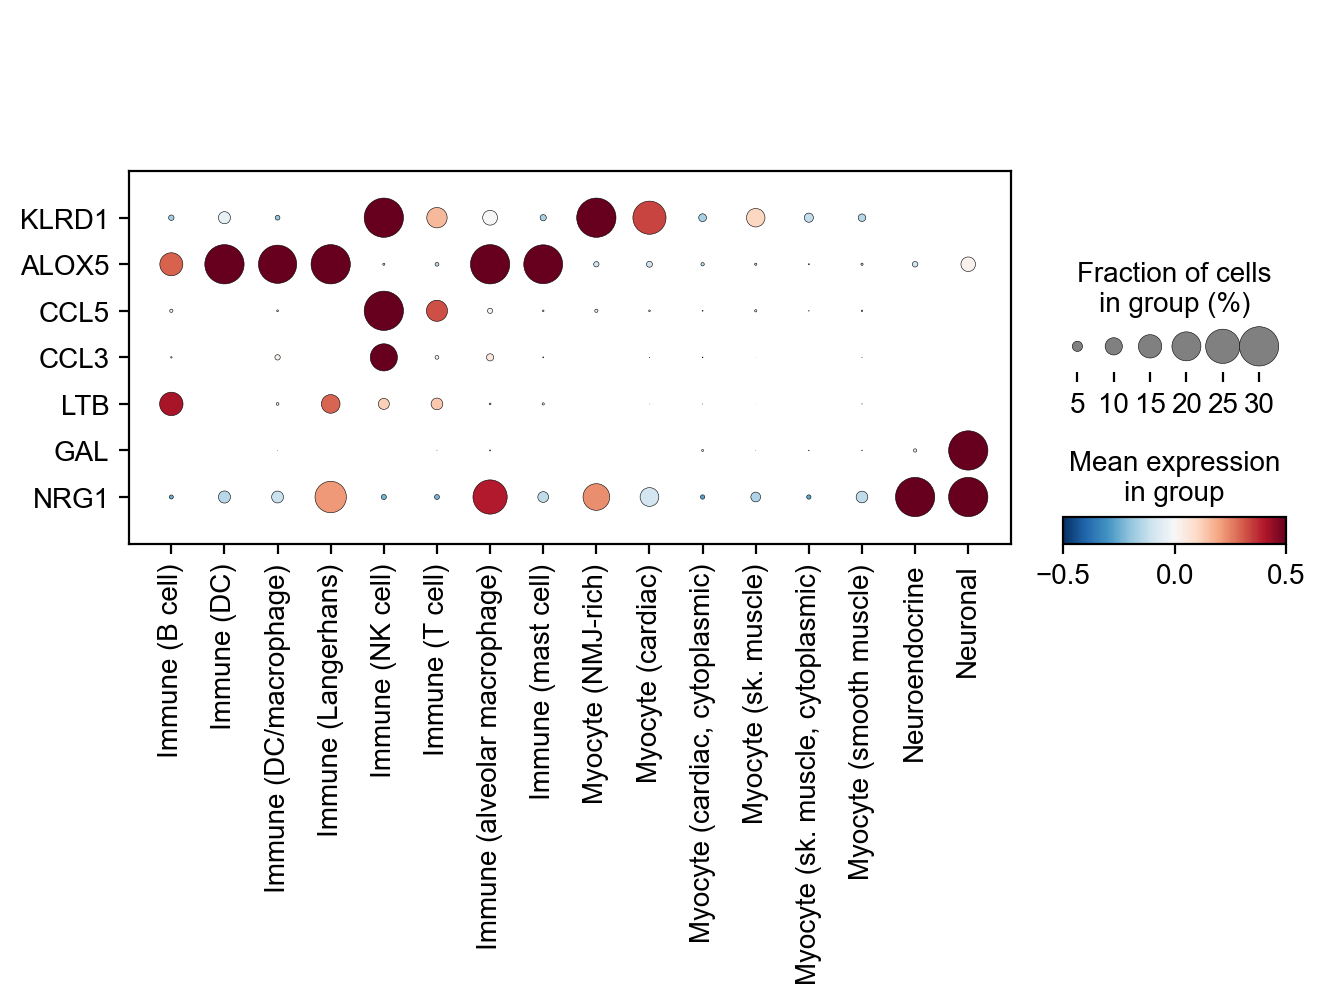

In [45]:
sc.pl.dotplot(tmp[tmp.obs['Broad cell type'].isin(types)], ['KLRD1', 'ALOX5', 'CCL5', 'CCL3', 'LTB', 'GAL', 'NRG1'], ['Broad cell type'], layer='scaled', vmin=-.5, vmax=.5, dot_max=.3, cmap='RdBu_r', swap_axes=True, save='hlaII-RL-nonimmune.pdf')

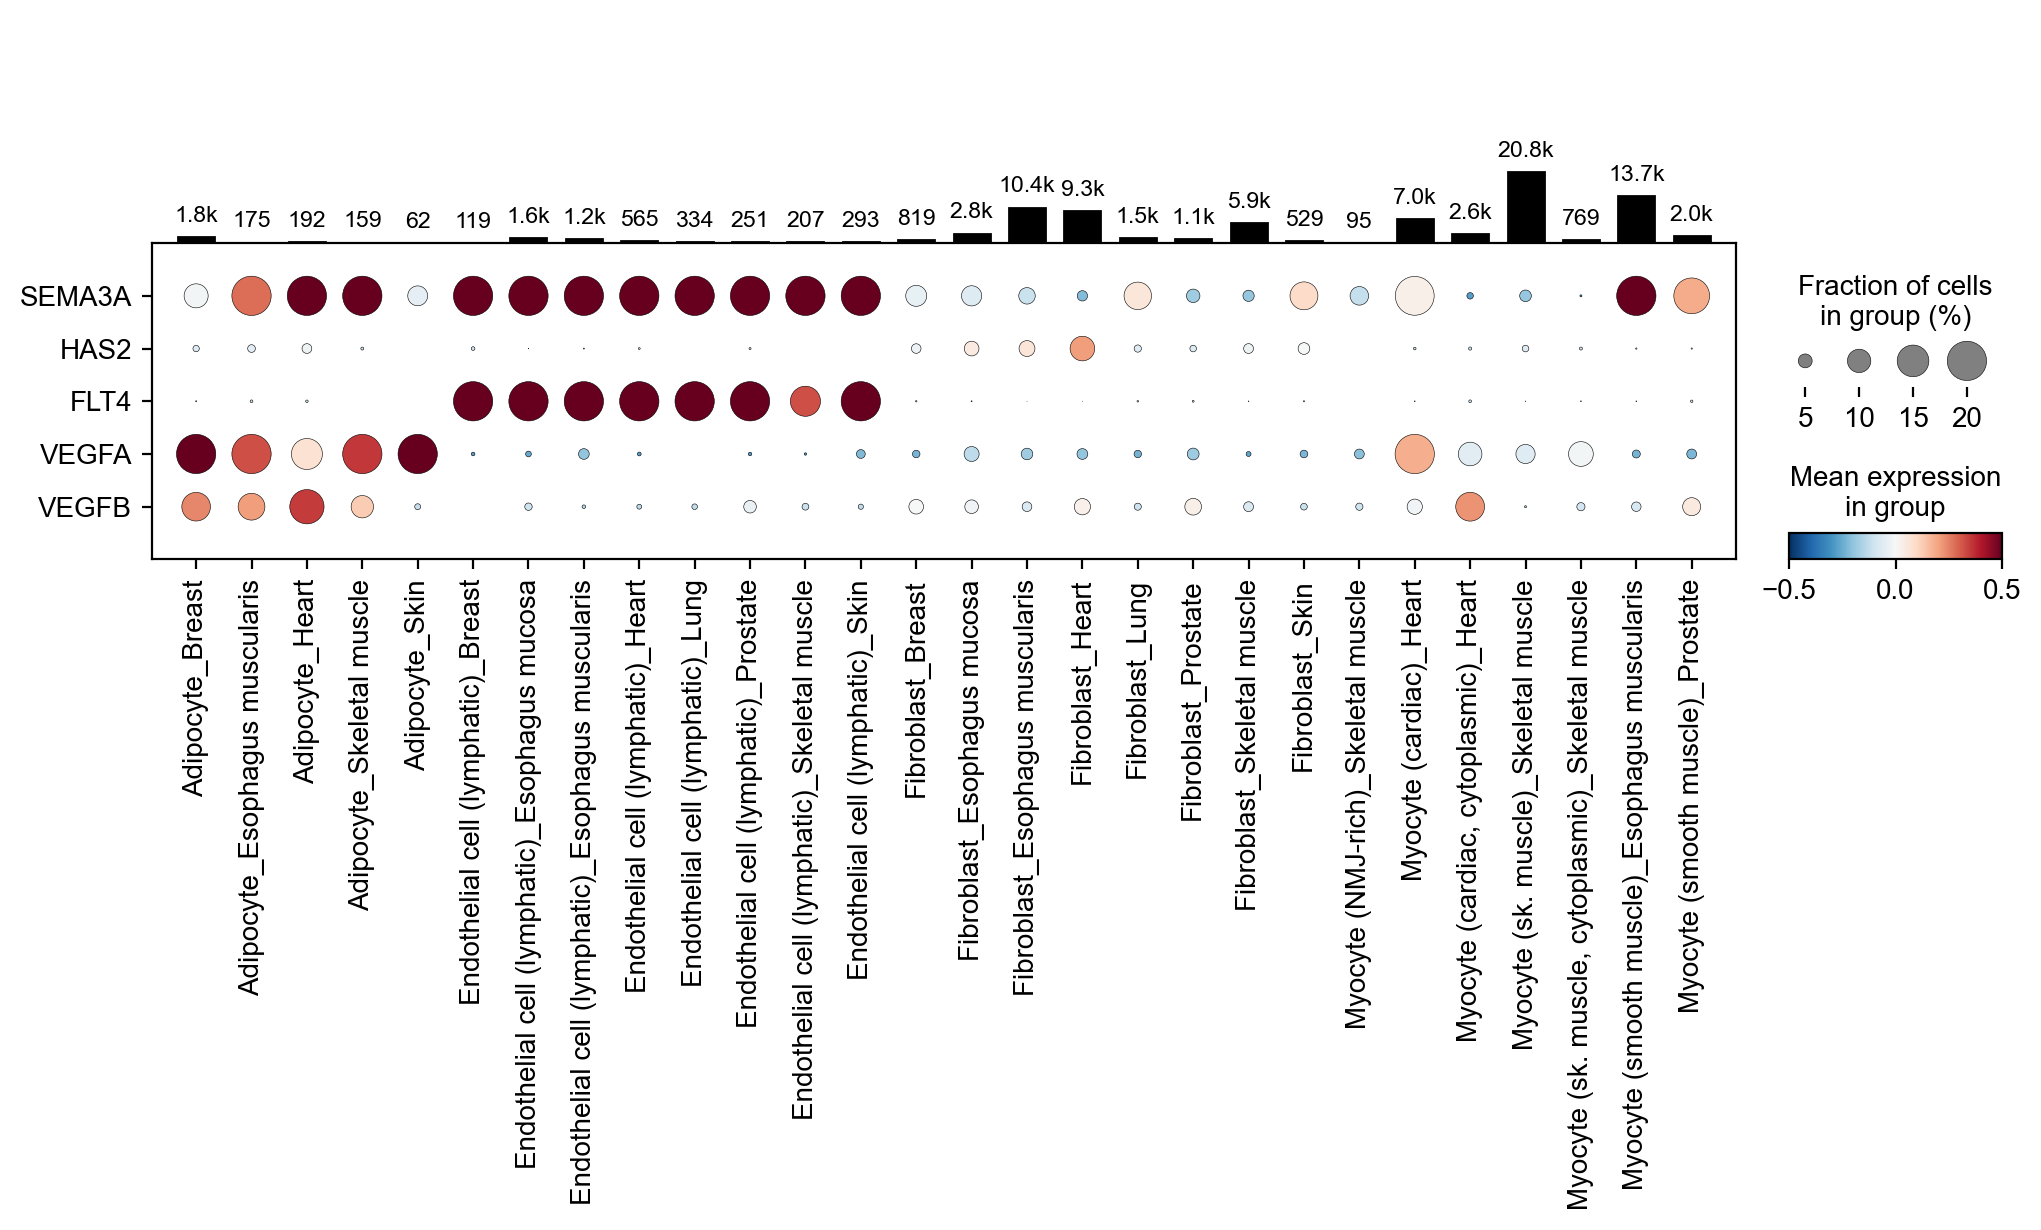

In [37]:
sc.pl.dotplot(nonimmune_ad, ['SEMA3A', 'HAS2', 'FLT4', 'VEGFA', 'VEGFB'], ['Broad cell type', 'Tissue'], return_fig=True, layer='scaled', vmin=-.5, vmax=.5, dot_max=.2, cmap='RdBu_r', swap_axes=True).add_totals(color='black').show()